In [10]:
# In this notebook we implement a simple open cv blob detector
import cv2 as cv
import numpy as np

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from itertools import chain

cv.__version__

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Getting sample data

In [11]:
# Setting up capture
path = '/Users/gert-janboth/Documents/flyTracker/data/movies/short_test.mp4'
cap = cv.VideoCapture(path)

In [12]:
# some properties of video
length = cap.get(cv.CAP_PROP_FRAME_COUNT) # works only on mp4's
width  = cap.get(cv.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv.CAP_PROP_FRAME_HEIGHT)
fps    = cap.get(cv.CAP_PROP_FPS)

print(length, fps, width, height)

120.0 25.0 1280.0 1080.0


In [13]:
# Getting all frames into a numpy array for easy working
movie = []
for _ in np.arange(length):
    #frame_grayscale = cv.cvtColor(cap.read()[1], cv.COLOR_BGR2GRAY)
    movie.append(cap.read()[1])
movie = np.array(movie)    

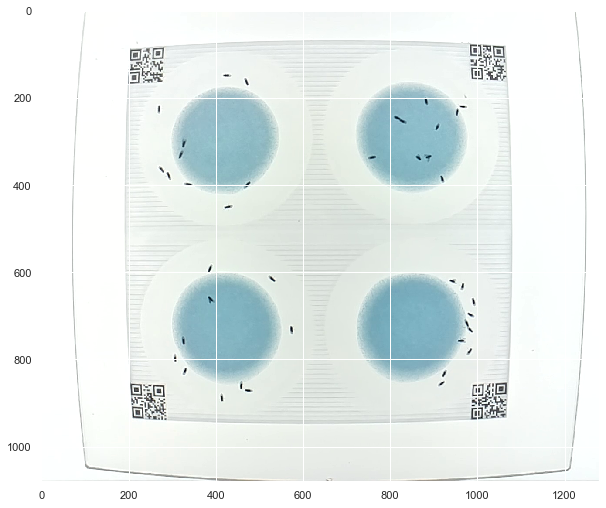

In [14]:
plt.figure(figsize=(10, 10))
frame = 99
plt.imshow(movie[frame])

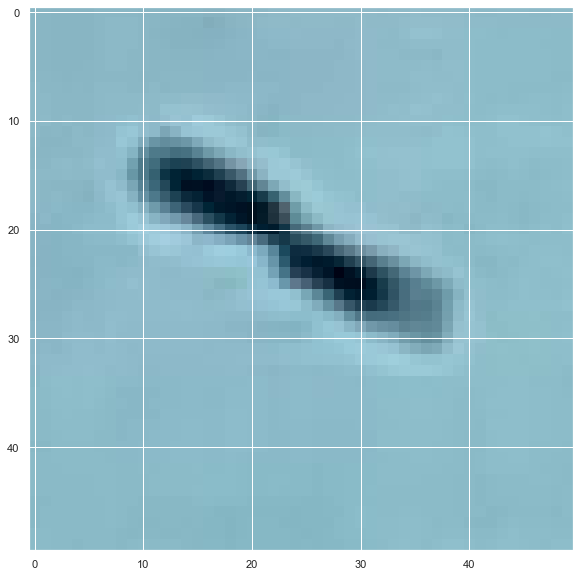

In [15]:
plt.figure(figsize=(10, 10))
frame = 99
plt.imshow(movie[frame, 230:280, 800:850])

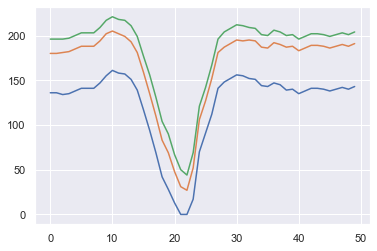

In [16]:
plt.plot(movie[frame, 250, 800:850])

# Preprocessing

In [17]:
from flytracker.preprocessing import OriginalPreprocessing

In [18]:
movie.shape[:3]

(120, 1080, 1280)

In [19]:
processed_movie = []
for idx in np.arange(movie.shape[0]):
    processed_frame = OriginalPreprocessing()(movie[idx])
    processed_movie.append(processed_frame)
processed_movie = np.array(processed_movie)

In [20]:
processed_movie.shape

(120, 1080, 1280)

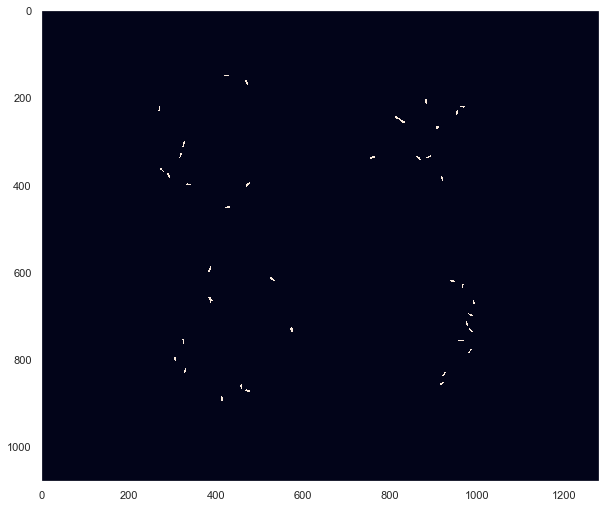

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(processed_movie[99])
plt.grid(False)

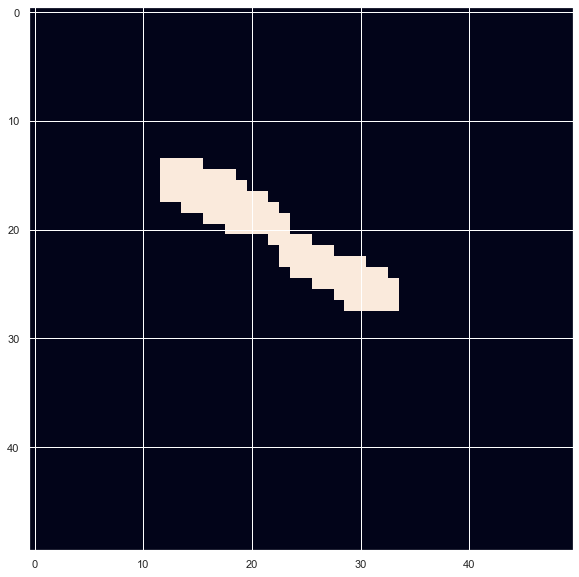

In [22]:
plt.figure(figsize=(10, 10))
frame = 99
plt.imshow(processed_movie[frame, 230:280, 800:850])

# Scikit image contour finding

In [71]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure
from skimage.color import rgb2gray


In [72]:
%%time

c = []
for frame in np.arange(100):
    # Construct some test data
    r = processed_movie[frame, :, :]

    # Find contours at a constant value of 0.8
    contours = measure.find_contours(r, 0.1)
    c.append(len(contours))

CPU times: user 988 ms, sys: 66.6 ms, total: 1.05 s
Wall time: 1.06 s


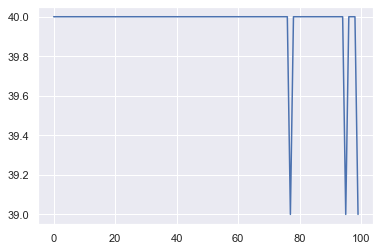

In [73]:
plt.plot(c)

# LoG

In [29]:
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

In [47]:
frame = 99
image_gray = rgb2gray(movie[frame])

In [66]:
blobs_log = blob_doh(processed_movie[frame], )

/opt/anaconda3/lib/python3.7/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/opt/anaconda3/lib/python3.7/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/opt/anaconda3/lib/python3.7/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/opt/anaconda3/lib/python3.7/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


CPU times: user 66.5 ms, sys: 2.44 ms, total: 69 ms
Wall time: 68.5 ms


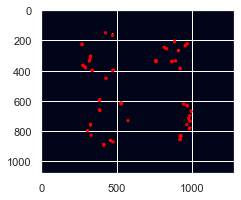

In [70]:
%%time
fig, ax = plt.subplots(figsize=(9, 3))
ax.imshow(processed_movie[frame])
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    ax.add_patch(c)

In [69]:
blobs_log[0][2]

4.222222222222222

In [44]:
%%time
frame = 0
blob_dog(rgb2gray(), max_sigma=20, threshold=0.5).shape

CPU times: user 1.23 s, sys: 94.5 ms, total: 1.32 s
Wall time: 1.33 s


(4, 3)

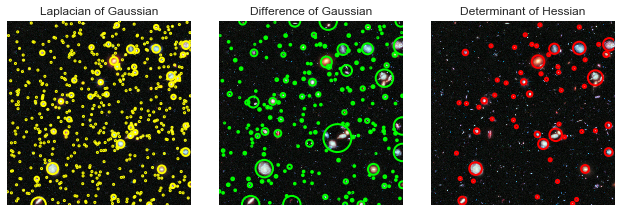

CPU times: user 2.45 s, sys: 63.6 ms, total: 2.51 s
Wall time: 2.52 s


In [46]:
%%time

from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()